In [1]:
import numpy as np
import pickle
from itertools import chain
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pylab as plt
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
import sys, os
sys.path.append(os.path.join(os.path.dirname("__file__"), '..', '..'))
from AI_scientist.util import plot_matrices, make_dir, get_struct_str, get_args, Early_Stopping, record_data, manifold_embedding
from AI_scientist.settings.filepath import variational_model_PATH, dataset_PATH
from AI_scientist.pytorch.net import Net
from AI_scientist.pytorch.util_pytorch import Loss_with_uncertainty
from AI_scientist.variational.util_variational import get_torch_tasks
from AI_scientist.variational.variational_meta_learning import Master_Model, Statistics_Net, Generative_Net, load_model_dict, get_regulated_statistics
from AI_scientist.variational.variational_meta_learning import VAE_Loss, sample_Gaussian, clone_net, get_nets, get_tasks, evaluate, get_reg, load_trained_models
from AI_scientist.variational.variational_meta_learning import plot_task_ensembles, plot_individual_tasks, plot_statistics_vs_z, plot_data_record, get_corrcoef
from AI_scientist.variational.variational_meta_learning import plot_few_shot_loss, plot_individual_tasks_bounce, plot_quick_learn_performance
from AI_scientist.variational.variational_meta_learning import get_latent_model_data, get_polynomial_class, get_Legendre_class, get_master_function

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
is_cuda = torch.cuda.is_available()

## Training:

In [ ]:
task_id_list = [
# "latent-linear",
# "polynomial-3",
# "Legendre-3",
# "M-sawtooth",
# "M-sin",
# "M-Gaussian",
# "M-tanh",
# "M-softplus",
# "C-sin",
"C-tanh",
# "bounce-states",
# "bounce-images",
]

num_shots = 10
exp_id = "C-May8"
exp_mode = "meta"
input_size = 1
is_VAE = False
is_uncertainty_net = False
is_regulated_net = False
is_load_data = False
VAE_beta = 0.2
if task_id_list[0] == "C-sin":
    statistics_output_neurons = 2
elif task_id_list[0] == "C-tanh":
    statistics_output_neurons = 4
elif task_id_list[0] in ["bounce-states", "bounce-images"]:
    statistics_output_neurons = 8

output_size = 1
lr = 5e-5
num_train_tasks = 50
num_test_tasks = 50
batch_size_task = min(50, num_train_tasks)
num_backwards = 1
num_iter = 10000
pre_pooling_neurons = 200
num_context_neurons = 0
statistics_pooling = "max"
main_hidden_neurons = (40, 40)
patience = 200
reg_amp = 1e-6
activation_gen = "leakyRelu"
activation_model = "leakyRelu"
optim_mode = "indi"
loss_core = "huber"
array_id = "new"

exp_id = get_args(exp_id, 1)
exp_mode = get_args(exp_mode, 2)
task_id_list = get_args(task_id_list, 3, type = "tuple")
statistics_output_neurons = get_args(statistics_output_neurons, 4, type = "int")
is_VAE = get_args(is_VAE, 5, type = "bool")
VAE_beta = get_args(VAE_beta, 6, type = "float")
lr = get_args(lr, 7, type = "float")
batch_size_task = get_args(batch_size_task, 8, type = "int")
pre_pooling_neurons = get_args(pre_pooling_neurons, 9, type = "int")
num_context_neurons = get_args(num_context_neurons, 10, type = "int")
statistics_pooling = get_args(statistics_pooling, 11)
main_hidden_neurons = get_args(main_hidden_neurons, 12, "tuple")
reg_amp = get_args(reg_amp, 13, type = "float")
activation_gen = get_args(activation_gen, 14)
activation_model = get_args(activation_model, 15)
optim_mode = get_args(optim_mode, 16)
is_uncertainty_net = get_args(is_uncertainty_net, 17, "bool")
loss_core = get_args(loss_core, 18)
array_id = get_args(array_id, 19)

try:
    %matplotlib inline
    isplot = True
except:
    isplot = False

# Settings:
reg_dict = {"statistics_Net": {"weight": reg_amp, "bias": reg_amp},
            "generative_Net": {"weight": reg_amp, "bias": reg_amp, "W_gen": reg_amp, "b_gen": reg_amp}}
task_settings = {
    "xlim": (-5, 5),
    "num_examples": 20,
    "test_size": 0.5,
}
struct_param_pre = [
        [60, "Simple_Layer", {}],
#         [60, "Simple_Layer", {}],
        [60, "Simple_Layer", {}],
        [pre_pooling_neurons, "Simple_Layer", {"activation": "linear"}],
    ]
struct_param_post = None
struct_param_gen_base = [
        [60, "Simple_Layer", {}],
#         [60, "Simple_Layer", {}],
        [60, "Simple_Layer", {}],
]
isParallel = False
inspect_interval = 50
save_interval = 100
filename = variational_model_PATH + "/trained_models/{0}/Net_{1}_{2}_input_{3}_({4},{5})_stat_{6}_pre_{7}_pool_{8}_context_{9}_hid_{10}_batch_{11}_back_{12}_VAE_{13}_{14}_uncer_{15}_lr_{16}_reg_{17}_actgen_{18}_actmodel_{19}_struct_{20}_{21}_core_{22}_{23}_".format(
    exp_id, exp_mode, task_id_list, input_size, num_train_tasks, num_test_tasks, statistics_output_neurons, pre_pooling_neurons, statistics_pooling, num_context_neurons, main_hidden_neurons, batch_size_task, num_backwards, is_VAE, VAE_beta, is_uncertainty_net, lr, reg_amp, activation_gen, activation_model, get_struct_str(struct_param_gen_base), optim_mode, loss_core, exp_id)
make_dir(filename)
print(filename)

# Obtain tasks:
assert len(task_id_list) == 1
dataset_filename = dataset_PATH + task_id_list[0] + "_{0}-shot.p".format(num_shots)
tasks = pickle.load(open(dataset_filename, "rb"))
tasks_train = get_torch_tasks(tasks["tasks_train"], task_id_list[0], is_cuda = is_cuda)
tasks_test = get_torch_tasks(tasks["tasks_test"], task_id_list[0], num_tasks = num_test_tasks, is_cuda = is_cuda)

# Obtain nets:
statistics_Net, generative_Net, generative_Net_logstd = get_nets(input_size = input_size, output_size = output_size, main_hidden_neurons = main_hidden_neurons,
                                          pre_pooling_neurons = pre_pooling_neurons, statistics_output_neurons = statistics_output_neurons, num_context_neurons = num_context_neurons,
                                          struct_param_pre = struct_param_pre,
                                          struct_param_gen_base = struct_param_gen_base,
                                          activation_statistics = activation_gen,
                                          activation_generative = activation_gen,
                                          activation_model = activation_model,
                                          statistics_pooling = statistics_pooling,
                                          isParallel = isParallel,
                                          is_VAE = is_VAE,
                                          is_uncertainty_net = is_uncertainty_net,
                                          is_cuda = is_cuda,
                                         )
if is_regulated_net:
    struct_param_regulated_Net = [
            [40, "Simple_Layer", {}],
            [40, "Simple_Layer", {}],
            [1, "Simple_Layer", {"activation": "linear"}],
    ]
    generative_Net = Net(input_size = input_size, struct_param = struct_param_regulated_Net, settings = {"activation": activation_model})
master_model = Master_Model(statistics_Net, generative_Net, generative_Net_logstd, is_cuda = is_cuda)

# Setting up optimizer and loss functions:
if is_uncertainty_net:
    optimizer = optim.Adam(chain.from_iterable([statistics_Net.parameters(), generative_Net.parameters(), generative_Net_logstd.parameters()]), lr = lr)
else:
    optimizer = optim.Adam(chain.from_iterable([statistics_Net.parameters(), generative_Net.parameters()]), lr = lr)

if loss_core == "mse":
    loss_fun_core = nn.MSELoss(size_average = True)
elif loss_core == "huber":
    loss_fun_core = nn.SmoothL1Loss(size_average = True) 
else:
    raise
if is_VAE:
    criterion = VAE_Loss(criterion = loss_fun_core, prior = "Gaussian", beta = VAE_beta)
else:
    if is_uncertainty_net:
        criterion = Loss_with_uncertainty(core = loss_core)
    else:
        criterion = loss_fun_core
early_stopping = Early_Stopping(patience = patience)

# Setting up recordings:
all_keys = list(tasks_train.keys()) + list(tasks_test.keys())
data_record = {"loss": {key: [] for key in all_keys}, "loss_sampled": {key: [] for key in all_keys}, "mse": {key: [] for key in all_keys},
               "reg": {key: [] for key in all_keys}, "KLD": {key: [] for key in all_keys}}
info_dict = {"array_id": array_id}
info_dict["data_record"] = data_record
info_dict["model_dict"] = []
record_data(data_record, [exp_id, tasks_train, tasks_test, task_id_list, task_settings, reg_dict, is_uncertainty_net, lr, pre_pooling_neurons, num_backwards, batch_size_task, 
                          struct_param_gen_base, struct_param_pre, struct_param_post, statistics_pooling, activation_gen, activation_model], 
            ["exp_id", "tasks_train", "tasks_test", "task_id_list", "task_settings", "reg_dict", "is_uncertainty_net", "lr", "pre_pooling_neurons", "num_backwards", "batch_size_task",
             "struct_param_gen_base", "struct_param_pre", "struct_param_post", "statistics_pooling", "activation_gen", "activation_model"])

# Training:
for i in range(num_iter + 1):
    chosen_task_keys = np.random.choice(list(tasks_train.keys()), batch_size_task, replace = False).tolist()
    if optim_mode == "indi":
        if is_VAE:
            KLD_total = Variable(torch.FloatTensor([0]), requires_grad = False)
            if is_cuda:
                KLD_total = KLD_total.cuda()
        for task_key, task in tasks_train.items():
            if task_key not in chosen_task_keys:
                continue
            ((X_train, y_train), (X_test, y_test)), _ = task
            for k in range(num_backwards):
                optimizer.zero_grad()
                if is_VAE:
                    statistics_mu, statistics_logvar = statistics_Net(torch.cat([X_train, y_train], 1))
                    statistics = sample_Gaussian(statistics_mu, statistics_logvar)
                    if is_regulated_net:
                        statistics = get_regulated_statistics(generative_Net, statistics)
                    y_pred = generative_Net(X_test, statistics)
                    loss, KLD = criterion(y_pred, y_test, mu = statistics_mu, logvar = statistics_logvar)
                    KLD_total = KLD_total + KLD
                else:
                    if is_uncertainty_net:
                        statistics_mu, statistics_logvar = statistics_Net(torch.cat([X_train, y_train], 1))
                        y_pred = generative_Net(X_test, statistics_mu)
                        y_pred_logstd = generative_Net_logstd(X_test, statistics_logvar)
                        loss = criterion(y_pred, y_test, log_std = y_pred_logstd)
                    else:
                        statistics = statistics_Net(torch.cat([X_train, y_train], 1))
                        if is_regulated_net:
                            statistics = get_regulated_statistics(generative_Net, statistics)
                        y_pred = generative_Net(X_test, statistics)
                        loss = criterion(y_pred, y_test)
                reg = get_reg(reg_dict, statistics_Net = statistics_Net, generative_Net = generative_Net, is_cuda = is_cuda)
                loss = loss + reg
                loss.backward(retain_graph = True)
                optimizer.step()
        # Perform gradient on the KL-divergence:
        if is_VAE:
            KLD_total = KLD_total / batch_size_task
            optimizer.zero_grad()
            KLD_total.backward()
            optimizer.step()
            record_data(data_record, [KLD_total], ["KLD_total"])
    elif optim_mode == "sum":
        optimizer.zero_grad()
        loss_total = Variable(torch.FloatTensor([0]), requires_grad = False)
        if is_cuda:
            loss_total = loss_total.cuda()
        for task_key, task in tasks_train.items():
            if task_key not in chosen_task_keys:
                continue
            ((X_train, y_train), (X_test, y_test)), _ = task
            if is_VAE:
                statistics_mu, statistics_logvar = statistics_Net(torch.cat([X_train, y_train], 1))
                statistics = sample_Gaussian(statistics_mu, statistics_logvar)
                y_pred = generative_Net(X_test, statistics)
                loss, KLD = criterion(y_pred, y_test, mu = statistics_mu, logvar = statistics_logvar)
                loss = loss + KLD
            else:
                if is_uncertainty_net:
                    statistics_mu, statistics_logvar = statistics_Net(torch.cat([X_train, y_train], 1))
                    y_pred = generative_Net(X_test, statistics_mu)
                    y_pred_logstd = generative_Net_logstd(X_test, statistics_logvar)
                    loss = criterion(y_pred, y_test, log_std = y_pred_logstd)
                else:
                    statistics = statistics_Net(torch.cat([X_train, y_train], 1))
                    y_pred = generative_Net(X_test, statistics)
                    loss = criterion(y_pred, y_test)
            reg = get_reg(reg_dict, statistics_Net = statistics_Net, generative_Net = generative_Net, is_cuda = is_cuda)
            loss_total = loss_total + loss + reg
        loss_total.backward()
        optimizer.step()
    else:
        raise Exception("optim_mode {0} not recognized!".format(optim_mode))
    

    loss_test_record = []
    for task_key, task in tasks_test.items():
        loss_test, _, _, _ = evaluate(task, statistics_Net, generative_Net, generative_Net_logstd = generative_Net_logstd, criterion = criterion, is_VAE = is_VAE, is_regulated_net = is_regulated_net)
        loss_test_record.append(loss_test)
    to_stop = early_stopping.monitor(np.mean(loss_test_record))

    # Validation and visualization:
    if i % inspect_interval == 0 or to_stop:
        print("=" * 50)
        print("training tasks:")
        for task_key, task in tasks_train.items():
            loss_test, loss_test_sampled, mse, KLD_test = evaluate(task, statistics_Net, generative_Net, generative_Net_logstd = generative_Net_logstd, criterion = criterion, is_VAE = is_VAE, is_regulated_net = is_regulated_net)
            reg = get_reg(reg_dict, statistics_Net = statistics_Net, generative_Net = generative_Net, is_cuda = is_cuda).data[0]
            data_record["loss"][task_key].append(loss_test)
            data_record["loss_sampled"][task_key].append(loss_test_sampled)
            data_record["mse"][task_key].append(mse)
            data_record["reg"][task_key].append(reg)
            data_record["KLD"][task_key].append(KLD_test)
            print('{0}\ttrain\t{1}  \tloss: {2:.5f}\tloss_sampled:{3:.5f} \tmse:{4:.5f}\tKLD:{5:.6f}\treg:{6:.6f}'.format(i, task_key, loss_test, loss_test_sampled, mse, KLD_test, reg))
        for task_key, task in tasks_test.items():
            loss_test, loss_test_sampled, mse, KLD_test = evaluate(task, statistics_Net, generative_Net, generative_Net_logstd = generative_Net_logstd, criterion = criterion, is_VAE = is_VAE, is_regulated_net = is_regulated_net)
            reg = get_reg(reg_dict, statistics_Net = statistics_Net, generative_Net = generative_Net, is_cuda = is_cuda).data[0]
            data_record["loss"][task_key].append(loss_test)
            data_record["loss_sampled"][task_key].append(loss_test_sampled)
            data_record["mse"][task_key].append(mse)
            data_record["reg"][task_key].append(reg)
            data_record["KLD"][task_key].append(KLD_test)
            print('{0}\ttrain\t{1}  \tloss: {2:.5f}\tloss_sampled:{3:.5f} \tmse:{4:.5f}\tKLD:{5:.6f}\treg:{6:.6f}'.format(i, task_key, loss_test, loss_test_sampled, mse, KLD_test, reg))
        loss_train_list = [data_record["loss"][task_key][-1] for task_key in tasks_train]
        loss_test_list = [data_record["loss"][task_key][-1] for task_key in tasks_test]
        loss_train_sampled_list = [data_record["loss_sampled"][task_key][-1] for task_key in tasks_train]
        loss_test_sampled_list = [data_record["loss_sampled"][task_key][-1] for task_key in tasks_test]
        mse_train_list = [data_record["mse"][task_key][-1] for task_key in tasks_train]
        mse_test_list = [data_record["mse"][task_key][-1] for task_key in tasks_test]
        reg_train_list = [data_record["reg"][task_key][-1] for task_key in tasks_train]
        reg_test_list = [data_record["reg"][task_key][-1] for task_key in tasks_test]
        mse_few_shot = plot_few_shot_loss(master_model, tasks_test, isplot = isplot)
        plot_quick_learn_performance(master_model, tasks_test)
        record_data(data_record, 
                    [np.mean(loss_train_list), np.median(loss_train_list), np.mean(reg_train_list), i,
                     np.mean(loss_test_list), np.median(loss_test_list), np.mean(reg_test_list),
                     np.mean(loss_train_sampled_list), np.median(loss_train_sampled_list), 
                     np.mean(loss_test_sampled_list), np.median(loss_test_sampled_list),
                     np.mean(mse_train_list), np.median(mse_train_list), 
                     np.mean(mse_test_list), np.median(mse_test_list), 
                     mse_few_shot,
                    ], 
                    ["loss_mean_train", "loss_median_train", "reg_mean_train", "iter",
                     "loss_mean_test", "loss_median_test", "reg_mean_test",
                     "loss_sampled_mean_train", "loss_sampled_median_train",
                     "loss_sampled_mean_test", "loss_sampled_median_test", 
                     "mse_mean_train", "mse_median_train", "mse_mean_test", "mse_median_test", 
                     "mse_few_shot",
                    ])
        if isplot:
            plot_data_record(data_record, idx = -1, is_VAE = is_VAE)
        print("Summary:")
        print('\n{0}\ttrain\tloss_mean: {1:.5f}\tloss_median: {2:.5f}\tmse_mean: {3:.6f}\tmse_median: {4:.6f}\treg: {5:.6f}'.format(i, data_record["loss_mean_train"][-1], data_record["loss_median_train"][-1], data_record["mse_mean_train"][-1], data_record["mse_median_train"][-1], data_record["reg_mean_train"][-1]))
        print('{0}\ttest\tloss_mean: {1:.5f}\tloss_median: {2:.5f}\tmse_mean: {3:.6f}\tmse_median: {4:.6f}\treg: {5:.6f}'.format(i, data_record["loss_mean_test"][-1], data_record["loss_median_test"][-1], data_record["mse_mean_test"][-1], data_record["mse_median_test"][-1], data_record["reg_mean_test"][-1]))
        if is_VAE and "KLD_total" in locals():
            print("KLD_total: {0:.5f}".format(KLD_total.data[0]))
        if isplot:
            plot_data_record(data_record, is_VAE = is_VAE)

        # Plotting y_pred vs. y_target:
        statistics_list_train, z_list_train = plot_task_ensembles(tasks_train, statistics_Net, generative_Net, is_VAE = is_VAE, is_regulated_net = is_regulated_net, title = "y_pred_train vs. y_train", isplot = isplot)
        statistics_list_test, z_list_test = plot_task_ensembles(tasks_test, statistics_Net, generative_Net, is_VAE = is_VAE, is_regulated_net = is_regulated_net, title = "y_pred_test vs. y_test", isplot = isplot)
        record_data(data_record, [np.array(z_list_train), np.array(z_list_test), np.array(statistics_list_train), np.array(statistics_list_test)], 
                    ["z_list_train_list", "z_list_test_list", "statistics_list_train_list", "statistics_list_test_list"])
        if isplot:
            print("train statistics vs. z:")
            plot_statistics_vs_z(z_list_train, statistics_list_train)
            print("test statistics vs. z:")
            plot_statistics_vs_z(z_list_test, statistics_list_test)

            # Plotting individual test data:
            if "bounce" in task_id_list[0]:
                plot_individual_tasks_bounce(tasks_test, num_examples_show = 40, num_tasks_show = 6, master_model = master_model, num_shots = 200)
            else:
                print("train tasks:")
                plot_individual_tasks(tasks_train, statistics_Net, generative_Net, generative_Net_logstd = generative_Net_logstd, is_VAE = is_VAE, is_regulated_net = is_regulated_net, xlim = task_settings["xlim"])
                print("test tasks:")
                plot_individual_tasks(tasks_test, statistics_Net, generative_Net, generative_Net_logstd = generative_Net_logstd, is_VAE = is_VAE, is_regulated_net = is_regulated_net, xlim = task_settings["xlim"])
        print("=" * 50 + "\n\n")
        try:
            sys.stdout.flush()
        except:
            pass
    if i % save_interval == 0 or to_stop:
        record_data(info_dict, [master_model.model_dict, i], ["model_dict", "iter"])
        pickle.dump(info_dict, open(filename + "info.p", "wb"))
    if to_stop:
        print("The training loss stops decreasing for {0} steps. Early stopping at {1}.".format(patience, i))
        break


# Plotting:
if isplot:
    for task_key in tasks_train:
        plt.semilogy(data_record["loss"][task_key], alpha = 0.6)
    plt.show()
    for task_key in tasks_test:
        plt.semilogy(data_record["loss"][task_key], alpha = 0.6)
    plt.show()
print("completed")
sys.stdout.flush()

## Testing:

In [ ]:
lr = 1e-3

print(dataset_filename)
tasks = pickle.load(open(dataset_filename, "rb"))
tasks_test = get_torch_tasks(tasks["tasks_test"], task_id_list[0], is_cuda = is_cuda)

task_keys_all = list(tasks_test.keys())
mse_list_all = []
for i in range(int(len(tasks_test) / 100)):
    print("{0}:".format(i))
    task_keys_iter = task_keys_all[i * 100: (i + 1) * 100]
    tasks_test_iter = {task_key: tasks_test[task_key] for task_key in task_keys_iter}
    mse = plot_quick_learn_performance(master_model, tasks_test_iter, lr = lr, epochs = 20)['model_0'].mean(0)
    mse_list_all.append(mse)

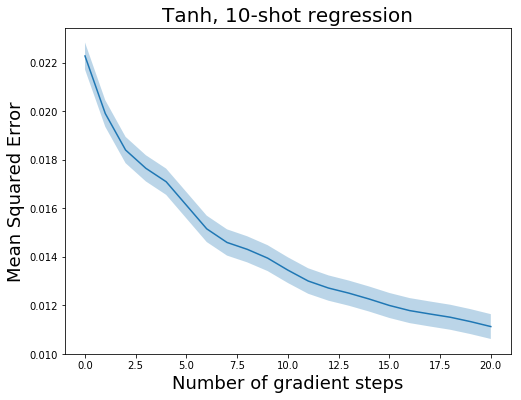

In [5]:
plt.figure(figsize = (8,6))
mse_list_all = np.array(mse_list_all)
mse_mean = mse_list_all.mean(0)
mse_std = mse_list_all.std(0)

plt.fill_between(range(len(mse_mean)), mse_mean - mse_std * 1.96 / np.sqrt(int(len(tasks_test) / 100)), mse_mean + mse_std * 1.96 / np.sqrt(int(len(tasks_test) / 100)), alpha = 0.3)
plt.plot(range(len(mse_mean)), mse_mean)
plt.title("Tanh, 10-shot regression", fontsize = 20)
plt.xlabel("Number of gradient steps", fontsize = 18)
plt.ylabel("Mean Squared Error", fontsize = 18)
plt.show()